# Análise Exploratória dos dados
![](https://raw.githubusercontent.com/PedroHCAlmeida/Projeto_final_bootcamp/main/img/charts1.png)
## Resumo
Este notebook foi destinado para análise exploratória do dataset disponibilizado pelo Hospital Sírio-Libanês no [kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19). A análise teve como objetivo, primeiramente, entender o dataset, pré-processar os dados de forma que seja possível usá-los como valores entrada a um algoritmo de Machine Learning, e após isso estudar proporções, correlações e variâncias com o objetivo de encontrar os possíveis caminhos ao se selecionar apenas os dados mais úteis para o problema. Por fim, os dados pré-processados foram salvos na pasta [dados/dados_preprocessados](https://github.com/PedroHCAlmeida/Projeto_final_bootcamp/tree/main/dados/dados_preprocessados), a fim de serem utilizados no notebook de [notebooks/Previsoes](https://github.com/PedroHCAlmeida/Projeto_final_bootcamp/blob/main/notebooks/Previsoes.ipynb).

## Importância do pré-processamento 
O pré-processamento dos dados em Machine Learning é um dos passos fundamentais em um projeto que se propõe a realizar previsões, a famosa frase **"garbage in, garbage out"** atribuída ao técnico da IBM George Fuechsel que significa, **"entra lixo, sai lixo"**, demonstra muito bem o porque essa fase é tão importante, se não prepararmos os nossos dados da maneira correta os resultados podem ser mentirosos, ou não ter utilidade alguma no final, e, muitas vezes podem passar despercebidos, por esta razão essas é uma das fases mais importantes na hora de manipular dados.<br>

Uma boa parte desse processo já foi realizado pela equipe do Hospital Sírio-Libanês, de acordo com o hospital esse conjunto de dados contém dados anonimizados coletados em São Paulo e em Brasília. Toda a anonimização desses dados seguiu as melhores práticas e recomendações internacionais, e os dados passaram por um processo de limpeza e normalização por coluna de acordo com os valores máximos e mínimos de forma que todos os valores estivessem no intervalo entre -1 e 1.<br>

## Estrutura dos dados

### Chave identificadora<br>
A coluna "PATIENT_VISIT_IDENTIFIER" é composta por números inteiros e é responsável por identificar cada paciente diferente.<br>
### Variável a ser prevista<br>
A variável a ser prevista é a coluna "ICU", que, no conjunto de dados original, indica se o paciente correspondente estava ou não na UTI naquela janela de tempo correspondente.<br>
### Janela de tempo<br>
De acordo com o Hospital a variável "WINDOW" diz respeito à janela de tempo onde as medições foram realizadas, ela está organizada da seguinte maneira:<br>

|Janela | Descrição|
|:-------------|:----------:|
|0-2 | Entre 0 até 2 horas a partir da admissão do paciente 
|2-4 | Entre 2 até 4 horas a partir da admissão do paciente 
|4-6 | Entre 4 até 6 horas a partir da admissão do paciente 
|6-12| Entre 6 até 12 horas a partir da admissão do paciente 
|Above-12| Mais de 12 horas horas a partir da admissão do paciente 

### Demais variáveis
As demais colunas do conjunto conjunto de dados trazem informações sobre:
* Informações demográficas do paciente (03)
* Grupos de doenças previamente identificadas pelos pacientes (09)
* Resultados de exames de sangue (36)
* Sinais vitais (06)<br>

No total são 54 variáveis, correspondente às médias, medianas, máximos, mínimos, diferenças e diferenças relativas dos dados do paciente.<br>

### Dados faltantes

Um dos maiores desafios ao se analisar dados médicos é a variação entre diferentes tipos de medições, por exemplo, os sinais vitais são coletados com mais frequência (geralmente de hora em hora) do que os laboratórios de sangue (geralmente diariamente).Fato esse acaba causando diversos dados faltantes uma vez que estamos analisando todos esses dados juntos em um mesmo conjunto.<br>

De acordo com o Hospital, para solucionar o problema dos dados faltantes, é razoável supor que um paciente que não tem uma medição registrada em uma janela de tempo esteja clinicamente estável, podendo apresentar sinais vitais e exames de sangue semelhantes às janelas vizinhas. Portanto, pode-se preencher os valores ausentes usando a entrada seguinte ou anterior.<br>  

# Problema a ser resolvido
A identificação precoce dos pacientes que desenvolverão um curso adverso da doença (e precisam de cuidados intensivos) é a chave para um tratamento adequado (salvar vidas) e para gerenciar leitos e recursos. Um bom modelo usando apenas a **primeira janela (0-2)** provavelmente será mais **clinicamente relevante**, por esta razão os dados serão reorganizados a fim de agrupar os dados médicos por paciente e apenas as informações da primeira janela serão utilizadas para identificar se um paciente precisou de internação em **qualquer uma das janelas**.

# Escopo do notebook
- Importação dos pacotes 
- Importação das funções locais 
- Leitura dos dados brutos
- Pré-processamento
- Análise da variável alvo
- Análise das informações demográficas
- Análise das demais variáveis categóricas
- Análise das variáveis numéricas
- Salvamento dos dados pré-processados

# Importação dos pacotes

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
#Configurando o estilo dos gráficos
sns.set_style('darkgrid')

#Filtrando os avisos
warnings.filterwarnings('ignore')

#Definindo a semente de números aleatórios
SEED = 64541

# Importação das funções locais

In [3]:
import os
os.chdir("../funcoes")
from feature import compute_chi2, compute_high_corr, binary_features
from my_plot import labs, annot_bar
from preprocessing import fill_table, select_window
os.chdir("../notebooks")

In [4]:
help(binary_features)

Help on function binary_features in module feature:

binary_features(data: pandas.core.frame.DataFrame)
    Função que recebe um DataFrame do pandas e verifica quais as colunas binárias.
    Realiza essa verificação consultando quantos valores únicos a coluna possui,
    qual o valor máximo e mínimo.
    OBS : os valores únicos precisam ser 1 e 0.
    
    Parâmetros:
    -----------
    data : DataFrame do pandas que será conferida quais as colunas binárias, tipo : pd.DataFrame
    
    Retorno:
    --------
    features : colunas binárias do dataframe, tipo : list



In [5]:
help(compute_chi2)

Help on function compute_chi2 in module feature:

compute_chi2(X: pandas.core.frame.DataFrame, y: pandas.core.series.Series)
    Recebe um dataframe do pandas com as colunas variáveis preditoras e uma Series do pandas da variável de reposta,
    calcula, através da função sklearn.model_selection.chi2, os p valores para cada coluna da hipótese nula 
    de que as variáveis preditoras são independentes da variável de reposta
    
    Parâmetros:
    -----------
    X : dataframe com as variáveis preditoras,tipo : pd.DataFrame,
        OBS: pode conter apenas uma coluna mas precisa ser do tipo pd.DataFrame
    y : Series do pandas da variável de resposta, tipo : pd.Series
    
    Retorno:
    -------
    p_values : dicionário contendo os p valores de cada coluna analisada, tipo : dict



In [6]:
help(compute_high_corr)

Help on function compute_high_corr in module feature:

compute_high_corr(data: pandas.core.frame.DataFrame, threshold: float = 0.95)
    Função que recebe um dataframe do pandas, calcula a matriz de correlação, seleciona o triângulo superior da matriz, 
    percorre as colunas verificando quais colunas apresentam uma correlação maior que o valor limite passado, em relação às linhas, 
    que nesse caso representam as colunas anteriores. 
    
    Parâmetros:
    -----------
    data : DataFrame do pandas com as variáveis a serem analisadas
    threshold : valor limite da correlação entre duas variáveis, ou seja, 
                se duas colunas que possuem uma correlação absoluta maior que esse valor uma das duas será eliminada,
                tipo : str, padrão : 0.95
    Retorno:
    --------
    cols_drop : colunas a serem eliminadas com base nas correlações, tipo : list



In [7]:
help(labs)

Help on function labs in module my_plot:

labs(ax, title: str = '', subtitle: str = '', xlabel: str = '', ylabel: str = '')
    Função que plota as informações adicionais dos gráficos, título, subtítulo, rótulos
    
    Parâmetros:
    ----------
    ax : eixo a ser plotado o gráfico, se nenhum for passado será criado automaticamnete, tipo : matplotlib.axes
    title : título do gráfico, tipo : str, padrão : ''
    subtitle : subtítulo do gráfico, tipo : str, padrão : ''
    xlabel : rótulo do eixo x, tipo : str, padrão : ''
    ylabel : rótulo do eixo y, tipo : str, padrão : ''



In [8]:
help(annot_bar)

Help on function annot_bar in module my_plot:

annot_bar(ax, prop=True, fontsize=15)
    Realiza anotações em cima das barras em um gráfico de barras 
    
    Parâmetros:
    -----------
    ax : eixo do matplotlib onde estão as barras, tipo : matplotlib.axes
    prop : indica se os valores serão representados como porcentagens ou não, tipo : bool, padrão : True
    fontsize : tamanho da fonte do texto, tipo : int, padrão : 15
    
    OBS : precisa ser chamada após o gráfico de barras



In [9]:
help(fill_table)

Help on function fill_table in module preprocessing:

fill_table(rows)
    Função que recebe as linhas correspondentes a apenas um paciente e preenche os 
    valores nulos das colunas contínuas com dados de outras janelas.
    Utiliza os métodos "ffill" e "bfill"
    
    Parâmetros:
    -----------
    rows : as linhas correspondentes ao mesmo paciente
    
    Retorno:
    --------
    Retorna as linhas preenchidas



In [10]:
help(select_window)

Help on function select_window in module preprocessing:

select_window(rows, window='0-2', target_variable='ICU')
    Função que seleciona a janela correspondente e verifica se em algum momento o paciente foi para UTI, 
    com isso modifica a coluna dependente para se em qualquer janela de tempo esse paciente foi para UTI
    
    Parâmetros:
    -----------
    rows : as linhas correspondentes ao mesmo paciente
    window : coluna correspondente à janela que será mantida, padrão : '0-2'
    target_variable : nome da variável dependente, padrão : 'ICU'
    
    Retono:
    -------
    Retorna o conjunto de dados preenchido



# Leitura dos dados brutos

Primeiramente, vou usar a função read_excel( ) para ler o arquivo .xlsx disponibilizado pelo Hospital Sírio-Libanês no [kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19), armazenando esses dados em um dataframe do pandas.

In [11]:
# Lendo os dados brutos 
df = pd.read_excel('../dados/dados_brutos/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx')

# Pré-Processamento

A fim de tratar os dados e usá-los da melhor forma para resolver o problema, temos que entender as variáveis e como está organizado o dataset, para isso vamos dar uma olhada nas primeiras linhas do mesmo.

In [12]:
df.head(10)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1
5,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
6,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,1
7,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,1
8,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.880952,-1.000000,-0.906832,-0.831132,-0.940967,-0.817204,-0.882574,-1.000000,6-12,1
9,1,1,90th,1,0.0,0.0,0.0,0.0,1.0,0.0,...,0.142857,-0.797980,0.315690,0.200359,-0.239515,0.645161,0.139709,-0.802317,ABOVE_12,1


Olhando para as primeiras linhas conseguimos perceber que a coluna "PATIENT_VISIT_IDENTIFIER", como o próprio nome sugere, é a coluna identificadora do paciente, portanto tal coluna deve ser usada de uma maneira que conseguimos agrupá-las por cada paciente e registrar se o paciente correspondente **foi para UTI em qualquer uma das janelas de tempo**.

In [13]:
df.shape

(1925, 231)

Observando o tamanho no dataset temos **1925** linhas, e **231** colunas, no entanto para o nosso problema precisamos que cada linha represente um paciente, porém antes de resolvermos esse problema, vamos olhar se existem dados faltantes no dataset.

In [14]:
df.isna().sum().sum()

223863

Somando os dados nulos de todas as colunas temos **223863** valores faltantes. Como foi divulgado pelo Hospital Sirío-Libanês, a fonte dos dados, podemos resolver esse problema preenchendo valores de janelas anteriores e posteriores, assumindo que esses valores não sofrem mudanças bruscas, e desde que usemos apenas **dados do mesmo paciente**. 

<br>Para isso vou agrupar os dados pela variável identificadora "PATIENT_VISIT_IDENTIFIER" e aplicar a função fill_table(), definida no arquivo [funcoes/preprocessing](https://github.com/PedroHCAlmeida/Projeto_final_bootcamp/blob/main/funcoes/preprocessing.py), essa função selecionará as colunas contínuas e realizará o preenchimento de dados nulos utilizando as técnicas de "bfill"(utilizando valores posteriores), e "ffil" utilizando valores anteriores. <br><br>

Além disso, temos o problema de que, uma vez que o objetivo é prever se um paciente irá precisar de cuidados intensivos com base nos valores da primeira janela de tempo, **não devemos utilizar dados de quando o paciente já estava na UTI para preencher dados anteriores("bfill")**. Para resolver esse problema vou agrupar os dados por duas variáveis, a variável identificadora("PATIENT_VISIT_IDENTIFIER") e a variável que indica se o paciente estava na UTI("ICU"), dessa forma apenas os dados que possuem o **mesmo valor de "PATIENT_VISIT_IDENTIFIER" e de "ICU"** serão utilizados para realizar o preenchimento de dados nulos.

In [15]:
# Agrupando os dados por "PATIENT_VISIT_IDENTIFIER" e "ICU" e aplicando a função fill_table
df = df.groupby(['PATIENT_VISIT_IDENTIFIER', 'ICU']).apply(fill_table)

In [16]:
df.isna().sum().sum()

8781

Após aplicar o preenchimento temos **8781** dados nulos. Esses dados nulos agora são informações faltantes que não podemos aplicar o preenchimento, por esta razão vou remover todas as linhas que possuem esses dados nulos.

In [17]:
# Eliminando dados nulos
df = df.dropna()

In [18]:
df.isna().sum().sum()

0

Resolvido o problema dos dados nulos, agora vamos resolver o problema das janelas de tempo. Para isso vou realizar os seguintes passos:
* Casos de pacientes que foram para **UTI nas duas primeiras horas** serão **desconsiderados** e eliminados do dataset.
* O dataframe será agrupado pela variável identificadora de cada paciente.
* Através da função select_window(), apenas a **linha referente a primeira janela de tempo(0-2)** de cada paciente continuará no dataset, e a variável "ICU" não vai mais depender da janela de tempo e indicará **se o paciente foi para UTI em qualquer momento**.
* A variável "WINDOW" será eliminada pois todos os dados se referem a primeira janela, e tal informação não possui mais relação com a variável alvo "ICU".
* A variável "PATIENT_VISIT_IDENTIFIER" será eliminada pois os dados foram agrupados e cada paciente será representado por apenas uma linha
* O index do dataframe será resetado por conta do agrupamento da variável "PATIENT_VISIT_IDENTIFIER".

In [19]:
#Selecionando as linhas onde o paciente chegou na UTI
rows_to_drop = df[(df['WINDOW'] == '0-2') & (df['ICU'] == 1)].index

#Eliminando as linhas do dataframe original
df.drop(index=rows_to_drop, inplace=True)

# Agrupando por paciente e aplicando a função select_window
df = df.groupby('PATIENT_VISIT_IDENTIFIER').apply(select_window)

#Não são mais úteis as variáveis da janela de tempo e do identificador
df.drop(['WINDOW', 'PATIENT_VISIT_IDENTIFIER'], axis=1, inplace=True)

#Resetando o index e eliminando essa informação 
df.reset_index(drop=True, inplace=True)

In [20]:
df.shape

(294, 229)

Por fim podemos ver que agora o dataset possui 294 linhas, que representam **294 pacientes**, e 229 colunas pois duas colunas foram eliminadas("WINDOW", "PATIENT_VISIT_IDENTIFIER").

Agora vamos investigar se os tipos dos dados estão corretos, para isso utilizarei a função info( ) que retorna informações técnicas do dataframe.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Columns: 229 entries, AGE_ABOVE65 to ICU
dtypes: float64(225), int64(3), object(1)
memory usage: 526.1+ KB


Percebe-se que temos 225 colunas do tipo numérico(float64), 3 colunas do tipo inteiro(int64) e 1 colunas de caracteres(object). Vamos investigar se era para ser dessa maneira mesmo.

In [22]:
df.head()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
1,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1
2,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
3,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0
4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0


Olhando o dataset parece haver diversas colunas que apresentam apenas valores 0 ou 1, variáveis categóricas binárias, como todas as variáveis indicando se o paciente pertence alguma doença dentro de algum grupo pré-definido, e portanto, devem ser classificadas como números inteiros.<br><br>
No entanto, foram identificadas apenas 3 variáveis inteiras, para resolver esse problema vou utilizar a função binary_features( ), definida no arquivo [funcoes/feature](https://github.com/PedroHCAlmeida/Projeto_final_bootcamp/blob/main/funcoes/feature.py), para definir quais as colunas binárias no dataframe e transformá-las em números inteiros.

In [23]:
binary = binary_features(df)
binary

['AGE_ABOVE65',
 'GENDER',
 'DISEASE GROUPING 1',
 'DISEASE GROUPING 2',
 'DISEASE GROUPING 3',
 'DISEASE GROUPING 4',
 'DISEASE GROUPING 5',
 'DISEASE GROUPING 6',
 'HTN',
 'IMMUNOCOMPROMISED',
 'OTHER',
 'ICU']

É possível perceber que realmente existem mais que 3 colunas binárias que deviam ser classificadas como tipo inteiro, por esta razão vou convertê-las para o tipo correto. 

In [24]:
df[binary] = df[binary].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Columns: 229 entries, AGE_ABOVE65 to ICU
dtypes: float64(216), int64(12), object(1)
memory usage: 526.1+ KB


Agora percebemos que temos 13 variáveis do tipo inteiro, 216 do tipo numérico e 1 do tipo caractere. Por fim vamos checar qual a coluna ele está identificando como caractere, uma vez que para um modelo de Machine Learning precisamos fornecer valores numéricos como entrada.

In [25]:
df.select_dtypes('object').head()

,AGE_PERCENTIL
0,60th
1,10th
2,40th
3,10th
4,10th


Podemos ver que a variável do tipo caractere é a "AGE_PERCENTIL", e realmente está classificada corretamente, porém vamos transformar essa variável de forma que um modelo de Machine Learning consiga entender, no entanto vou realizar essa transformação quando analisar essa variável separadamente na parte de Análise de informações demográficas, para assim entender o melhor a se fazer. 

# Análise da variável alvo

Um dos maiores problemas ao tentar resolver problemas com Machine Learning é o desbalanceamento em relação a variável alvo. Por exemplo, podemos ter muitos dados de pessoas que foram para UTI e poucos que não foram, ou vice-versa, e isso pode fazer o modelo criar um viés na hora de modelar as relações das variáveis. Por esta razão vou analisar a quantidade de pacientes que precisaram ir para UTI e pacientes que não precisaram ir para UTI.

In [26]:
df['ICU']

0      1
1      1
2      0
3      0
4      0
      ..
289    1
290    0
291    1
292    0
293    0
Name: ICU, Length: 294, dtype: int64

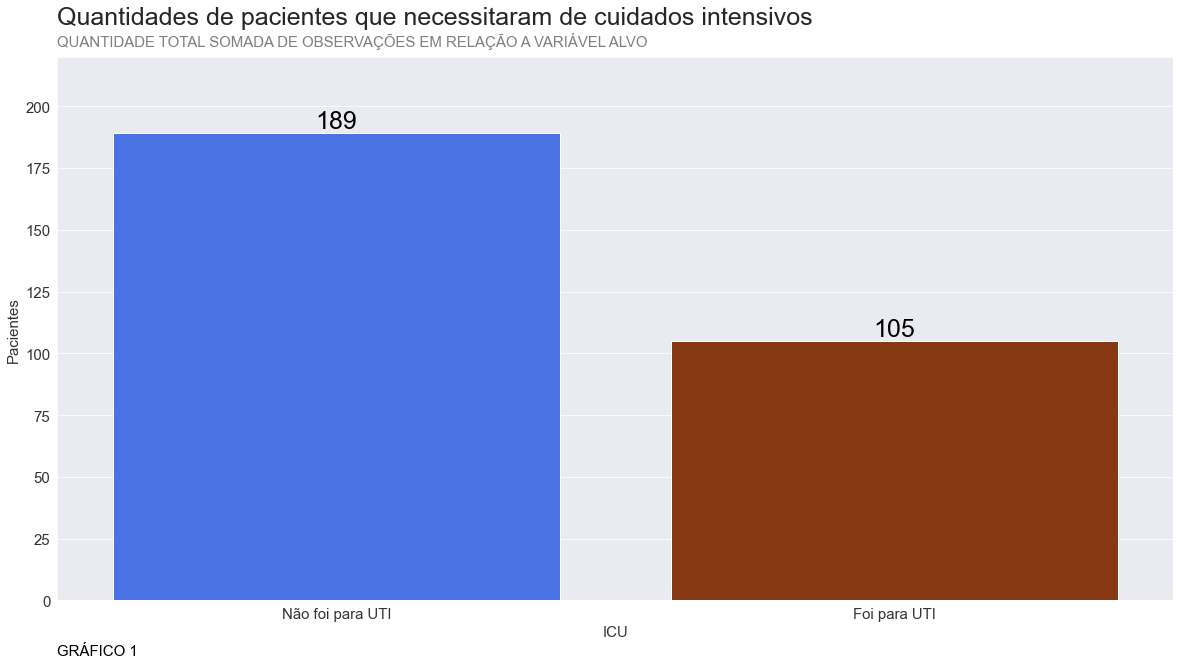

In [27]:
#Criando a figura
fig, ax = plt.subplots(figsize=(20,10)) 

#Criando o gráfico
sns.countplot(df['ICU'], ax=ax, palette=['#3366ff', '#993300'])

#Plotando rótulos e títulos
labs(title='Quantidades de pacientes que necessitaram de cuidados intensivos',
     subtitle='QUANTIDADE TOTAL SOMADA DE OBSERVAÇÕES EM RELAÇÃO A VARIÁVEL ALVO',
     xlabel='ICU', ylabel='Pacientes',ax=ax)

#Anotando em cima das barras
annot_bar(prop=False, ax=ax, fontsize=25)

#Definindo eixo y
plt.ylim([0,220])

#Configurando o eixo x
plt.xticks(range(2),['Não foi para UTI', 'Foi para UTI'])

#Adicionando uma referência para o gráfico
plt.text(0,-0.1, 'GRÁFICO 1', color='black', transform=ax.transAxes, fontsize=15)
plt.show()

Observando o gráfico 1 fica claro que a maioria dos pacientes presentes no dataset não precisaram de cuidados intensivos, fato este que apoia a realização de uma reamostragem a fim de balancear o dataframe em relação a variável "ICU", porém essa reamostragem será realizada e testada apenas quando formos comparar os modelos de Machine Learning no notebook [notebooks/Previsoes](https://github.com/PedroHCAlmeida/Projeto_final_bootcamp/blob/main/notebooks/Previsoes.ipynb).

# Análise das informações demográficas

De acordo com o Sirío-Libanês o dataset possui 3 variáveis demográficas, para identificá-las vamos observar novamente as primeiras linhas.

In [28]:
df.head()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
0,1,60th,0,0,0,0,0,1,1,0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
1,0,10th,0,0,0,0,0,0,0,0,...,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1
2,0,40th,1,0,0,0,0,0,0,0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
3,0,10th,0,0,0,0,0,0,0,0,...,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0
4,0,10th,0,0,0,0,0,0,0,0,...,-1.000000,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0


Fica claro que essas informações são representadas pelas colunas "AGE_ABOVE65", "AGE_PERCENTIL" e "GENDER", e dizem respeito a idade e genêro dos pacientes.

### Coluna "AGE_PERCENTIL"

A primeira coluna analisada será a coluna "AGE_PERCENTIL", que traz informações sobre a idade dos pacientes. No entanto temos um problema nessa variável, como foi identificado anteriormente, ela foi representada através de caracteres representando o percentil da idade.
<br><br>
Pensando em modelos de Machine Learning precisamos transformá-la em uma variável inteira ou numérica, para decidir como realizar essa transformação vou analisar como a variável alvo "ICU" se comporta em relação a cada percentil de idade, para isso vou calcular qual a porcentagem de pacientes que foram para UTI para cada valor dessa coluna.

In [29]:
# Agrupando o dataframe pela variável "AGE_PERCENTIL" e calculando a proporção de pessoas que foram para UTI 
percentil_prop = df.groupby('AGE_PERCENTIL')['ICU'].value_counts(normalize=True).reset_index(name='Prop')
percentil_prop

,AGE_PERCENTIL,ICU,Prop
0,10th,0,0.833333
1,10th,1,0.166667
2,20th,0,0.815789
3,20th,1,0.184211
4,30th,0,0.676471
5,30th,1,0.323529
6,40th,0,0.757576
7,40th,1,0.242424
8,50th,0,0.580645
9,50th,1,0.419355


Com a tabela pronta podemos visualizar em um gráfico esse comportamento.

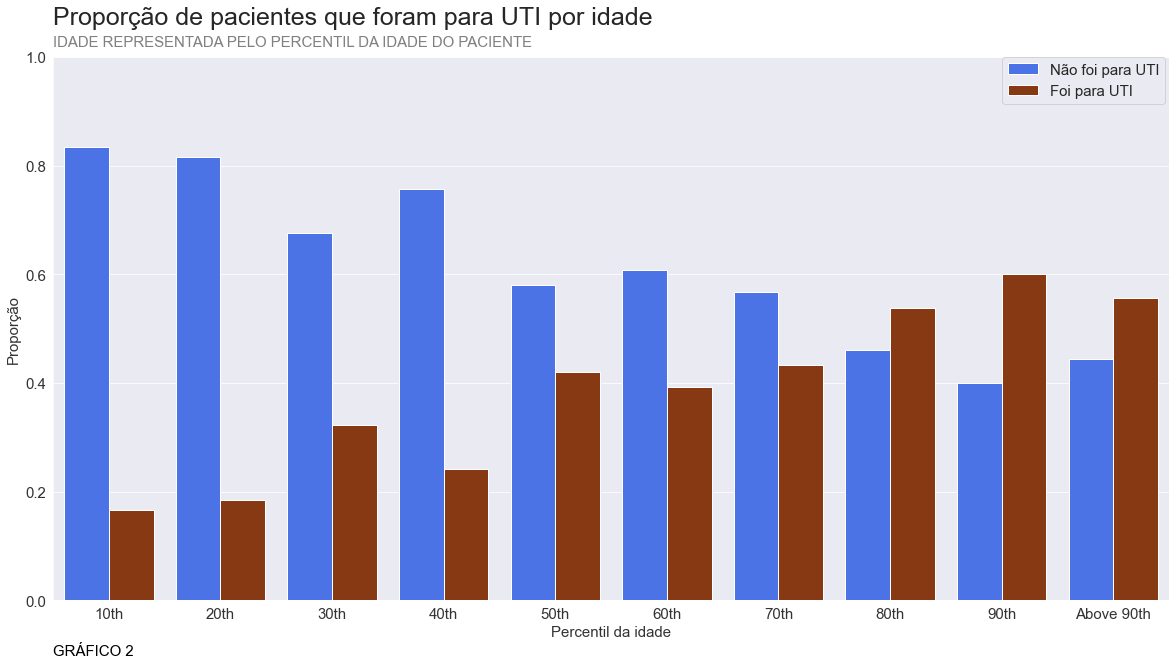

In [30]:
#Criando a figura
fig, ax = plt.subplots(figsize=(20,10)) 

#Criando o gráfico
sns.barplot(data=percentil_prop, y='Prop', x='AGE_PERCENTIL', hue='ICU', ax=ax, palette=['#3366ff', '#993300'])

#Plotando rótulos e títulos
labs(title='Proporção de pacientes que foram para UTI por idade', subtitle='IDADE REPRESENTADA PELO PERCENTIL DA IDADE DO PACIENTE',
     xlabel='Percentil da idade', ylabel='Proporção',ax=ax)
#Configurando a legenda
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Não foi para UTI', 'Foi para UTI'], bbox_to_anchor=(0.85, 1), loc=2, borderaxespad=0., fontsize=15)

#Definindo o eixo y
plt.ylim([0,1])

#Adicionando uma referência para o gráfico
plt.text(0,-0.1, 'GRÁFICO 2', color='black', transform=ax.transAxes, fontsize=15)
plt.show()

Observando o gráfico 2 fica claro que dependendo da idade há uma proporção de pacientes diferentes que precisaram de cuidados intensivos. Além disso parece haver faixas etárias onde essa proporção sofre um aumento, por esta razão vou utilizar essa informação a fim de criar colunas categóricas binárias com base na faixa etária, a partir do gráfico decidi transformá-la nas seguintes colunas:

|Coluna | Descrição|
|:-------------|:----------:|
|"AGE_UNDER_30th" | Pacientes com idade abaixo dos 30 anos
|"AGE_UNDER_50th" | Pacientes com idade abaixo dos 50 anos
|"AGE_ABOVE_50th"| Pacientes com idade acima dos 50 anos
|"AGE_ABOVE_80th"| Pacientes com idade acima dos 80 anos

In [31]:
#Criando as colunas com base no percentil da idade
df['AGE_UNDER_30th']=[1 if row['AGE_PERCENTIL'] in ['10th', '20th'] 
                      else 0 for _,row in df.iterrows()] 

df['AGE_UNDER_50th']=[1 if row['AGE_PERCENTIL'] in ['10th', '20th','30th', '40th'] 
                      else 0 for _,row in df.iterrows()] 

df['AGE_ABOVE_50th']=[1 if row['AGE_PERCENTIL'] in ['50th','60th', '70th','80th', '90th', 'Above 90th'] 
                      else 0 for _,row in df.iterrows()]

df['AGE_ABOVE_80th']=[1 if row['AGE_PERCENTIL'] in ['80th', '90th', 'Above 90th'] 
                      else 0 for _,row in df.iterrows()] 

# Eliminando a coluna "AGE_PERCENTIL" original
df.drop('AGE_PERCENTIL', axis=1, inplace=True)
df.head()

,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,...,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU,AGE_UNDER_30th,AGE_UNDER_50th,AGE_ABOVE_50th,AGE_ABOVE_80th
0,1,0,0,0,0,0,1,1,0,0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1,1,1,0,0
2,0,1,0,0,0,0,0,0,0,1,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0,1,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0,1,1,0,0


Agora com o problema da coluna Percentil resolvido temos 6 colunas demográficas, todas elas do tipo inteiro e categóricas.

### Teste de Chi Quadrado

Considerando que essas informações demográficas não possuem uma influência das demais variáveis, vou analisar cada uma individualmente, verificando se elas possuem alguma relação de dependência com a variável alvo, ou seja, a variável "ICU". Para isso vou realizar um teste de Chi Quadrado de Pearson com significância de **5%** para decidir se alguma dessas variáveis deve ser retirada.<br>
Este teste vai testar a seguinte hipótese:

### $H_0$ : Colunas demográficas são independentes em relação a variável alvo('ICU')
### $H_a$ : Colunas demográficas são dependentes em relação a variável alvo('ICU') 

![](https://raw.githubusercontent.com/PedroHCAlmeida/Projeto_final_bootcamp/main/img/img017.png)

### Variáveis de idade

Para visualizar melhor as relações dessa variáveis com a variável "ICU" vou calcular a proporção de pessoas que foram para UTI para cada valor 0 ou 1 dessas variáveis, ou seja, dado que um paciente pertence a um grupo ele tem mais chance de ir para UTI do quem não pertence.

In [32]:
#Selecionando as variáveis
ages = ['AGE_UNDER_30th','AGE_UNDER_50th','AGE_ABOVE_50th','AGE_ABOVE_80th','AGE_ABOVE65', 'ICU']

#Transformando as colunas em uma coluna "variable" e os valores em uma coluna "value" e mantendo a variável "ICU" fixa
ages_melt = pd.melt(df[ages], id_vars='ICU')

#Calculando a proporção da variável "ICU" para cada combinação "variable"(coluna), "value"(valor)
ages_prop = ages_melt.groupby(['variable','value'])['ICU'].mean().reset_index(name='Prop')

In [33]:
ages_prop

,variable,value,Prop
0,AGE_ABOVE65,0,0.260116
1,AGE_ABOVE65,1,0.495868
2,AGE_ABOVE_50th,0,0.226950
3,AGE_ABOVE_50th,1,0.477124
4,AGE_ABOVE_80th,0,0.300000
5,AGE_ABOVE_80th,1,0.562500
6,AGE_UNDER_30th,0,0.418182
7,AGE_UNDER_30th,1,0.175676
8,AGE_UNDER_50th,0,0.477124
9,AGE_UNDER_50th,1,0.226950


Com a tabela pronta indicando a proporção, para cada valor de cada variável de idade, podemos visualizar em um gráfico esse comportamento.

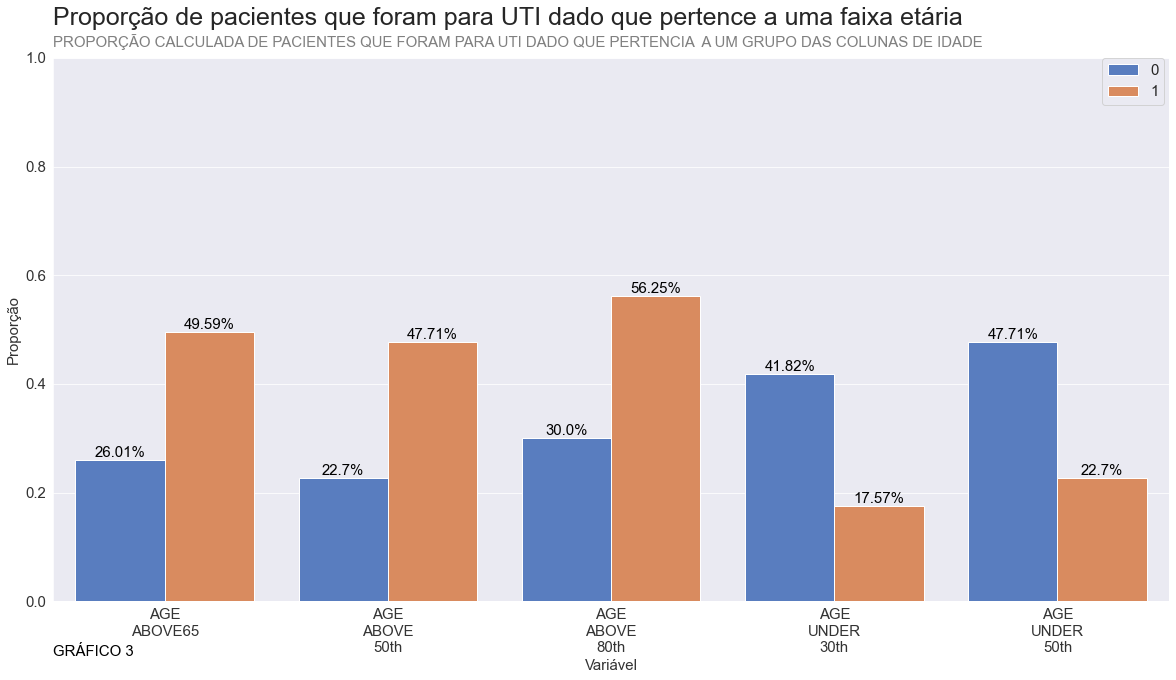

In [34]:
#Criando a figura
fig, ax = plt.subplots(figsize=(20,10)) 

#Criando o gráfico
sns.barplot(data=ages_prop, y='Prop', x='variable', hue='value', ax=ax, palette='muted')

#Plotando rótulos e títulos
labs(title='Proporção de pacientes que foram para UTI dado que pertence a uma faixa etária', 
     subtitle='PROPORÇÃO CALCULADA DE PACIENTES QUE FORAM PARA UTI DADO QUE PERTENCIA  A UM GRUPO DAS COLUNAS DE IDADE',
     xlabel='Variável', ylabel='Proporção',ax=ax)

#Configurando a legenda
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['0','1'], bbox_to_anchor=(0.94, 1), loc=2, borderaxespad=0., fontsize=15)

#Configurando o eixo x
plt.xticks(range(5),labels=ages_prop['variable'].str.split(r'_| ').str.join('\n').unique())

#Anotando em cima das barras
annot_bar(ax)

#Definindo o eixo y
plt.ylim([0,1])

#Adicionando uma referência para o gráfico
plt.text(0,-0.1, 'GRÁFICO 3', color='black', transform=ax.transAxes, fontsize=15)
plt.show()

A partir do gráfico 3 parece que as variáveis de idade influenciam se o paciente vai ou não para UTI, para confirmar tal afirmação vou realizar um teste de Chi-Quadrado através da função compute_chi2( ), definida no arquivo [funcoes/feature](https://github.com/PedroHCAlmeida/Projeto_final_bootcamp/blob/main/funcoes/feature.py), essa função nos retorna os p valores para cada uma das variáveis, e se, algum deles for maior que **5%** não rejeitaremos a hipótese nula de que a variável é independente da variável alvo "ICU".

In [35]:
#Calculando os p valores para colunas de idade
p_values = compute_chi2(df[ages].drop('ICU', axis=1), df['ICU'])
for col, p_value in p_values.items():
    print(f'Considerando a hipótese nula de que a coluna {col} é independente da variável alvo "ICU"\n\
    obteve-se um p valor igual a {np.round(p_value,4)}')

Considerando a hipótese nula de que a coluna AGE_UNDER_30th é independente da variável alvo "ICU"
    obteve-se um p valor igual a 0.0011
Considerando a hipótese nula de que a coluna AGE_UNDER_50th é independente da variável alvo "ICU"
    obteve-se um p valor igual a 0.0013
Considerando a hipótese nula de que a coluna AGE_ABOVE_50th é independente da variável alvo "ICU"
    obteve-se um p valor igual a 0.002
Considerando a hipótese nula de que a coluna AGE_ABOVE_80th é independente da variável alvo "ICU"
    obteve-se um p valor igual a 0.0006
Considerando a hipótese nula de que a coluna AGE_ABOVE65 é independente da variável alvo "ICU"
    obteve-se um p valor igual a 0.0014


Analisando o p valor das colunas relacionadas às idades dos pacientes no teste de Chi-Quadrado da hipótese nula das variáveis serem independentes do paciente ir para UTI, todos os p valores foram **menores que 5%**, por esta razão temos evidências para **rejeitar a hipótese nula** e, por isso, essas variávies serão mantidas no dataframe.

### Variável de genêro

A outra variável demográfica é a variável de genêro, para identificar se o genêro influencia vamos repetir o mesmo processo.

In [36]:
#Construindo um dataframe com a coluna "GENDER" e "ICU", mantendo o "ICU" fixo e tranformando a coluna "GENDER" em duas uma para o nome 
#da variável("variable") e outra para os valores correspondentes("value")
gender_melt  = pd.melt(df[['GENDER', 'ICU']], id_vars='ICU')

#Calculando a proporção da variável "ICU" para cada combinação "variable"(coluna), "value"(valor)
gender_prop = gender_melt.groupby(['variable','value'])['ICU'].mean().reset_index(name='Prop')

In [37]:
gender_prop

,variable,value,Prop
0,GENDER,0,0.408840
1,GENDER,1,0.274336


Com a tabela pronta indicando a proporção de pacientes que foram para UTI dependendo do genêro podemos visualizar em um gráfico esse comportamento.

**OBS: POR CONTA DA ANONIMIZAÇÃO DOS DADOS NÃO FOI INFORMADO QUAL GENÊRO É REPRESENTADO POR QUAL NÚMERO, POR ISSO SERÁ REPRESENTADO COMO 0 e 1**

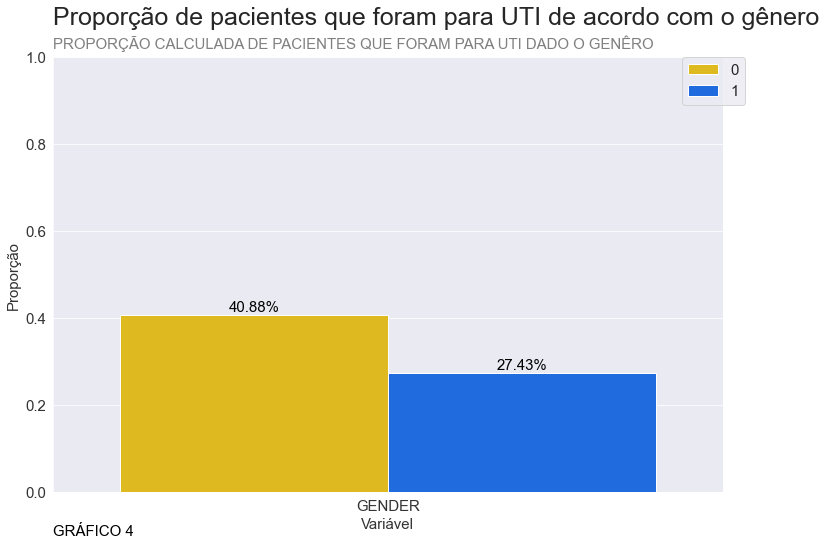

In [38]:
#Criando a figura
fig, ax = plt.subplots(figsize=(12,8)) 

#Criando o gráfico
sns.barplot(data=gender_prop, y='Prop', x='variable', hue='value', ax=ax, palette=['#ffcc00','#0066ff'])

#Plotando rótulos e títulos
labs(title='Proporção de pacientes que foram para UTI de acordo com o gênero', 
     subtitle='PROPORÇÃO CALCULADA DE PACIENTES QUE FORAM PARA UTI DADO O GENÊRO',
     xlabel='Variável', ylabel='Proporção',ax=ax)

#Configurando a legenda
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['0','1'], bbox_to_anchor=(0.94, 1), loc=2, borderaxespad=0., fontsize=15)

#Anotando em cima das barras
annot_bar(ax)

#Definindo o eixo y
plt.ylim([0,1])

#Adicionando uma referência para o gráfico
plt.text(0,-0.1, 'GRÁFICO 4', color='black', transform=ax.transAxes, fontsize=15)
plt.show()

A partir do gráfico 4 percebe-se que dependendo do genêro parece haver uma diferença na chance de ir para UTI, porém vamos realizar um teste de Chi-Quadrado para decidir se essa variável será mantida.

In [39]:
p_value_gender = compute_chi2(df[['GENDER']], df['ICU'])
print(f'Considerando a hipótese nula de que a coluna GENDER é independente da variável alvo "ICU" obteve-se um p valor igual a \
      {np.round(p_value_gender["GENDER"],4)}')

Considerando a hipótese nula de que a coluna GENDER é independente da variável alvo "ICU" obteve-se um p valor igual a       0.0662


Analisando o p valor da coluna de genêro no teste de Chi-Quadrado da hipótese nula da variável ser **independente** do paciente ir para **UTI**, foi maior que **5%**, portanto **não temos evidências para rejeitar a hipótese nula** e por esta razão vou eliminar a coluna "GENDER" do dataframe.

In [40]:
#Eliminando a coluna "GENDER"
df.drop('GENDER', axis=1, inplace=True)

# Análise das demais variáveis categóricas

Além das colunas demográficas, as colunas que nos dizem se o paciente possui alguma doença ou alguma condição de saúde também são colunas categóricas binárias, portanto, podemos realizar o mesmo processo para visualizar as proporções e realizar um teste de Chi-Quadrado<br><br>
No entanto, **não realizarei este teste**. Tomei esta decisão pois acredito que essas variáveis possuem uma relação direta com a saúde de um paciente e podem sofrer uma influência muito grande de outros fatores, como por exemplo, uma doença pode se agravar com a idade e, portanto, a proporção de pacientes que precisaram ir para UTI dado que esse paciente possui uma certa condição de saúde pode ser diferente dependendo da idade, o que não seria levado em conta em um teste realizado individualmente para cada variável.

In [41]:
#Selecionando as variáveis categóricas a respeito das doenças e condições médicas
diseases = ['DISEASE GROUPING 1','DISEASE GROUPING 2','DISEASE GROUPING 3','DISEASE GROUPING 4',\
            'DISEASE GROUPING 5','DISEASE GROUPING 6','HTN','IMMUNOCOMPROMISED','OTHER', 'ICU']

In [42]:
#Construindo um dataframe com as colunas relacionadas as doenças e "ICU", mantendo o "ICU" fixo e tranformando as demais colunas 
#em duas que representarão o nome da variável("variable") e outra os valores correspondentes("value")
diseases_melt  = pd.melt(df[diseases], id_vars='ICU')

#Calculando a proporção da variável "ICU" para cada combinação "variable"(coluna), "value"(valor)
diseases_prop = diseases_melt.groupby(['variable','value'])['ICU'].mean().reset_index(name='Prop')

In [43]:
diseases_prop

,variable,value,Prop
0,DISEASE GROUPING 1,0,0.349624
1,DISEASE GROUPING 1,1,0.428571
2,DISEASE GROUPING 2,0,0.348432
3,DISEASE GROUPING 2,1,0.714286
4,DISEASE GROUPING 3,0,0.338290
5,DISEASE GROUPING 3,1,0.560000
6,DISEASE GROUPING 4,0,0.347222
7,DISEASE GROUPING 4,1,0.833333
8,DISEASE GROUPING 5,0,0.338462
9,DISEASE GROUPING 5,1,0.500000


Com a tabela pronta indicando a proporção de pacientes que foram para UTI, dado que possuia alguma condição de saúde, podemos visualizar em um gráfico esse comportamento.<br>
**OBS: POR CONTA DA ANONIMIZAÇÃO DOS DADOS NÃO FOI INFORMADO O QUE REPRESENTA CADA GRUPO DE DOENÇA**

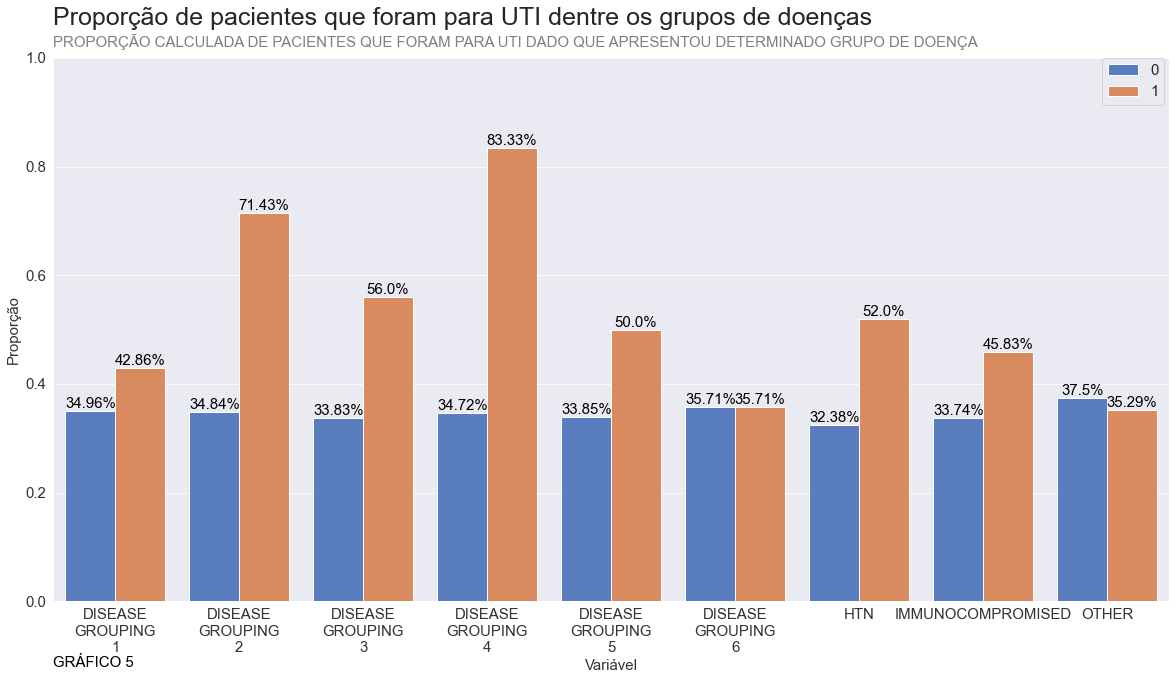

In [44]:
#Criando a figura
fig, ax = plt.subplots(figsize=(20,10)) 

#Criando o gráfico
sns.barplot(data=diseases_prop, y='Prop', x='variable', hue='value', ax=ax, palette='muted')

#Plotando rótulos e títulos
labs(title='Proporção de pacientes que foram para UTI dentre os grupos de doenças', 
     subtitle='PROPORÇÃO CALCULADA DE PACIENTES QUE FORAM PARA UTI DADO QUE APRESENTOU DETERMINADO GRUPO DE DOENÇA',
     xlabel='Variável', ylabel='Proporção',ax=ax)

#Configurando a legenda
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['0','1'], bbox_to_anchor=(0.94, 1), loc=2, borderaxespad=0., fontsize=15)

#Configurando o eixo x
plt.xticks(range(9),labels=diseases_prop['variable'].str.split(r'_| ').str.join('\n').unique())

#Anotando em cima das barras
annot_bar(ax)

#Definindo o eixo y
plt.ylim([0,1])

#Adicionando uma referência para o gráfico
plt.text(0,-0.12, 'GRÁFICO 5', color='black', transform=ax.transAxes, fontsize=15)
plt.show()

A partir do gráfico 5 parece que algumas condições não apresentam uma chance maior de ir para UTI dado que o paciente possuia tal condição, por exemplo as variáveis "DISEASE GROUPING 6" e "OTHER", possuem proporções muito próximas, independente do valor. 
<br><br>
No entanto, como foi mencionado anteriormente, não aplicarei nenhum teste para removê-las, e manterei no dataset por enquanto.

# Análise das variáveis numéricas

Como foi visto no início deste notebook, o dataset que estamos analisando possuem muitas colunas e, a maior parte delas eram numéricas. A fim de estudar se todas essas variáveis são importantes na hora de criar um modelo de Machine Learning existem algumas técnicas que podem ser aplicadas, como por exemplo:<br>

* Análise de correlação : se tivermos em nosso dataset muitas variáveis que estão altamente correlacionadas elas podem ser representados com apenas uma dessas colunas, por exemplo, em vez de ter 5 colunas que trazem a mesma informação, de modo de que quando uma aumente a outra possua um comportamento semelhante, aumentando ou descrescendo na mesma intensidade, podemos eliminar 4 delas e manter apenas 1 dessas colunas.<br><br>
* Análise de variância : colunas com uma variância igual a 0, ou seja, possuem o mesmo valor em todo o dataset não trazem nenhuma informação em relação a variável alvo e podem ser todas eliminadas.

## Análise de correção entre as variáveis

Para entender se existem colunas com uma correlação muito alta em nosso dataset, vamos observar um mapa de calor com as correlações calculadas para cada combinação de colunas.

**OBS: A CORRELAÇÃO SERÁ CALCULADA EM FORMA DE MÓDULO, OU SEJA, MEDINDO A FORÇA DESSA CORRELAÇÃO INDEPENDENTE DO SINAL(positiva ou negativa)**

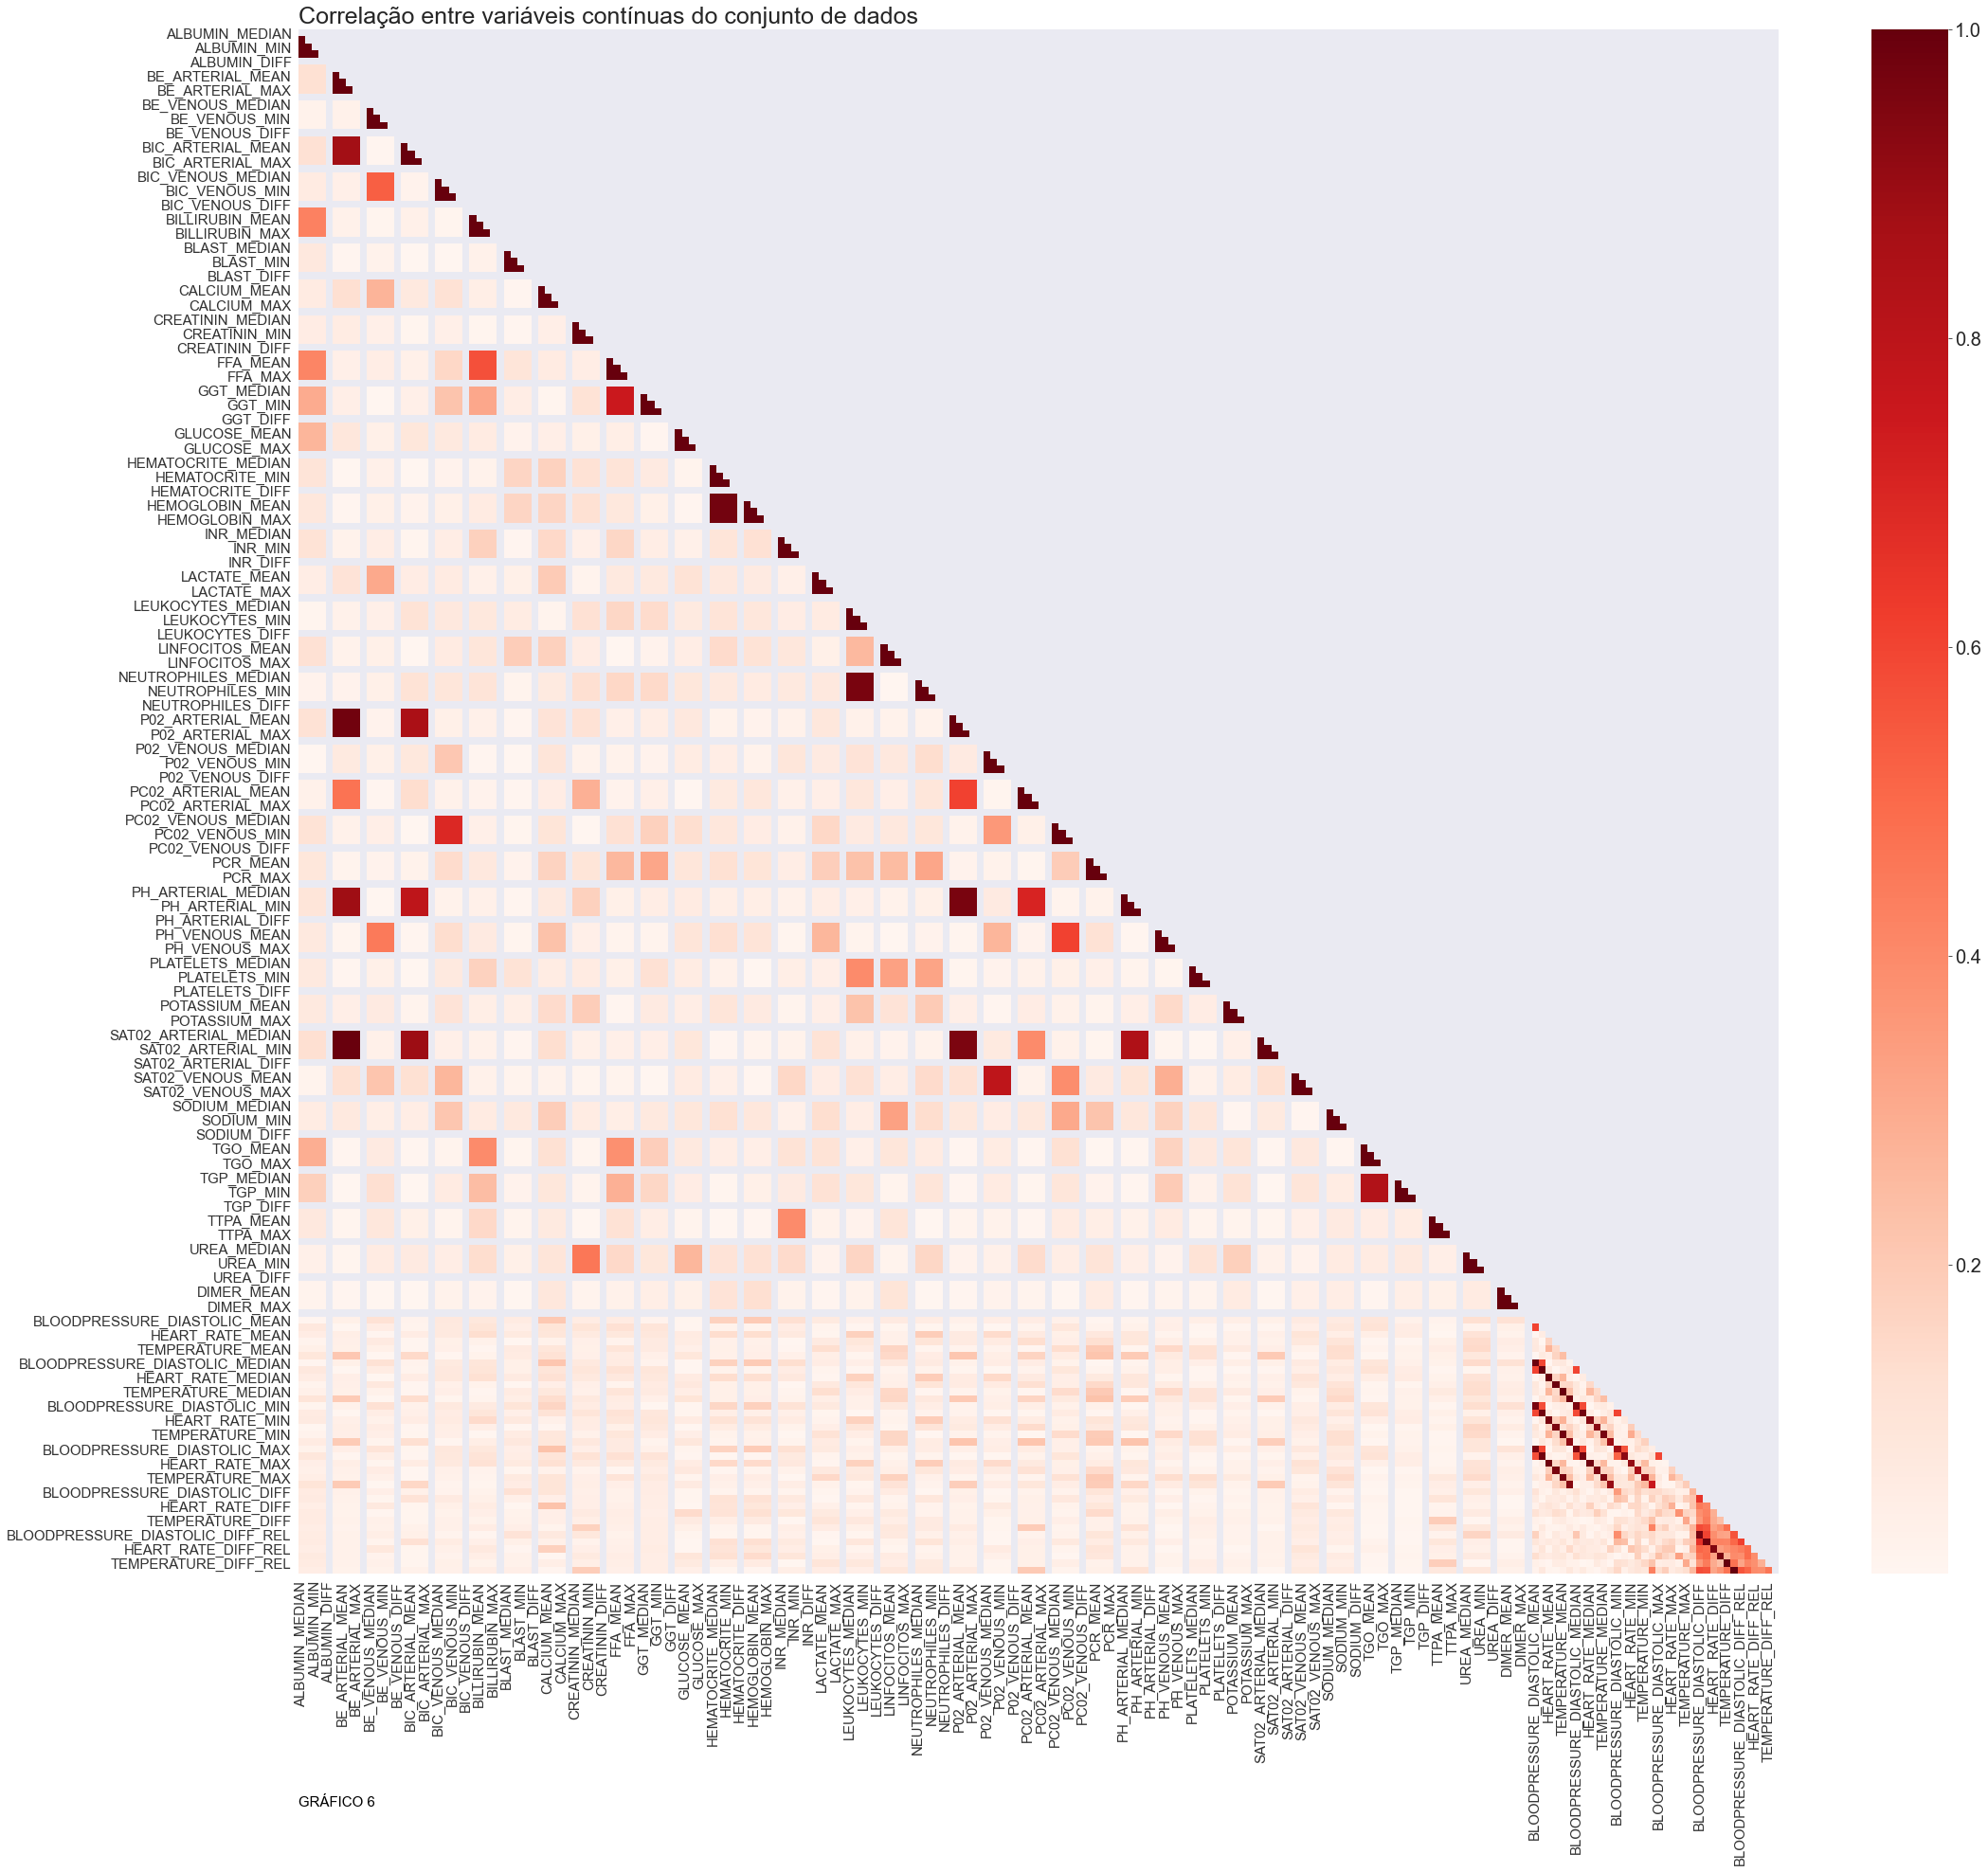

In [45]:
#Criando a figura
fig,ax = plt.subplots(figsize=(35, 30))

#Criando a matriz de correlação absoluta usando apenas colunas contínuas
cor = df.select_dtypes('float64').corr().abs()

#Criando uma máscara para ocultar a diagonal e a parte triangular superior da matriz
mask = np.triu(np.ones_like(cor, dtype=bool))

#Criando o gráfico
sns.heatmap(cor,
            cmap='Reds',
            mask=mask,
            ax=ax)

#Plotando rótulos e títulos
labs(title='Correlação entre variáveis contínuas do conjunto de dados', ax=ax)

#Mudando o tamnho da fonte da barra de cor
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)

#Adicionando uma referência para o gráfico
plt.text(0,-0.15, 'GRÁFICO 6', color='black', transform=ax.transAxes, fontsize=15)
plt.show()

A partir do gráfico 6 percebemos que muitas colunas possuem uma alta correlação absoluta, ou seja, temos uma motivação para eliminar colunas correlacionadas de forma que apenas uma delas continue no dataset.<br><br>
Para isso, vou utilizar a função compute_high_corr( ), definida no arquivo [funcoes/feature](https://github.com/PedroHCAlmeida/Projeto_final_bootcamp/blob/main/funcoes/feature.py), que irá calcular a matriz de correlação das colunas e percorrer essa matriz de tal forma que se uma coluna tiver uma correlação mais alta que o valor de corte em relação a alguma coluna que já foi percorrida ela será armazenada em uma lista e essa lista será retornada ao final, ou seja, em um grupo onde existem diversas colunas correlacionas apenas uma delas será mantida.

In [46]:
#Calculando as colunas para eliminar com um valor de corte de 0.95
cols_drop_high_corr = compute_high_corr(df.select_dtypes('float64'), 0.95)
#Mostrando na tela essas colunas
print(cols_drop_high_corr)
#Mostrando na tela a quantidade de colunas
print(len(cols_drop_high_corr))

['ALBUMIN_MEAN', 'ALBUMIN_MIN', 'ALBUMIN_MAX', 'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MIN', 'BE_ARTERIAL_MAX', 'BE_VENOUS_MEAN', 'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'BIC_ARTERIAL_MEAN', 'BIC_ARTERIAL_MIN', 'BIC_ARTERIAL_MAX', 'BIC_VENOUS_MEAN', 'BIC_VENOUS_MIN', 'BIC_VENOUS_MAX', 'BILLIRUBIN_MEAN', 'BILLIRUBIN_MIN', 'BILLIRUBIN_MAX', 'BLAST_MEAN', 'BLAST_MIN', 'BLAST_MAX', 'CALCIUM_MEAN', 'CALCIUM_MIN', 'CALCIUM_MAX', 'CREATININ_MEAN', 'CREATININ_MIN', 'CREATININ_MAX', 'FFA_MEAN', 'FFA_MIN', 'FFA_MAX', 'GGT_MEAN', 'GGT_MIN', 'GGT_MAX', 'GLUCOSE_MEAN', 'GLUCOSE_MIN', 'GLUCOSE_MAX', 'HEMATOCRITE_MEAN', 'HEMATOCRITE_MIN', 'HEMATOCRITE_MAX', 'HEMOGLOBIN_MEDIAN', 'HEMOGLOBIN_MEAN', 'HEMOGLOBIN_MIN', 'HEMOGLOBIN_MAX', 'INR_MEAN', 'INR_MIN', 'INR_MAX', 'LACTATE_MEAN', 'LACTATE_MIN', 'LACTATE_MAX', 'LEUKOCYTES_MEAN', 'LEUKOCYTES_MIN', 'LEUKOCYTES_MAX', 'LINFOCITOS_MEAN', 'LINFOCITOS_MIN', 'LINFOCITOS_MAX', 'NEUTROPHILES_MEDIAN', 'NEUTROPHILES_MEAN', 'NEUTROPHILES_MIN', 'NEUTROPHILES_MAX', 'P02_ARTERIA

Podemos perceber que, de acordo com a função compute_high_corr( ), podemos eliminar essas 134 colunas pois existem outras colunas no dataset que possuem uma alta correlação com estas.

In [47]:
df.drop(cols_drop_high_corr, axis=1, inplace=True)

## Análise da variância 

Outro fator que podemos analisar de forma fácil e, já nos diz muito sobre determinada variável, é a variância. Esta é uma medida usada para mensurar a dispersão dos dados em um conjunto, ou seja, quanto menor essa variância mais agrupados estão os valores. <br>

Uma vez que nós estamos trabalhando com dados normalizados, como foi informado pelo Sírio-Libanês, fica difícil ter uma referência de qual o valor mínimo de uma variância para uma variável ser considerada importante, no entanto, temos uma certeza, se alguma das variáveis possui uma **variância igual a zero**, é porque ela é **completamente desnecessária** ao se resolver o nosso problema.

Para analisar este fato, primeiramente vou olhar para o boxplot de 15 colunas aleatórias a fim de encontrar algo que possamos analisar, ou, conseguimos ver se alguma dessas colunas possui variância zero.

In [48]:
#Setando a semente aletória que foi definida no começo do notebook
np.random.seed(SEED)

#Selecionando o dataset com as colunas contínuas
cont = df.select_dtypes('float64')

#Escolhendo o dataset com 15 colunas aleatórias
sample = cont[np.random.choice(cont.columns, size=15, replace=False)]

#Juntando com a informação da variável alvo para analisar a diferença entre os grupos
sample_cont = pd.concat([sample, df['ICU']],axis=1) 

#Transformando as colunas em uma coluna "variable" e os valores em uma coluna "value" e mantendo a variável "ICU" fixa 
cont_melt = pd.melt(sample_cont, id_vars='ICU')

In [49]:
cont_melt.head()

,ICU,variable,value
0,1,SODIUM_DIFF,-1.0
1,1,SODIUM_DIFF,-1.0
2,0,SODIUM_DIFF,-1.0
3,0,SODIUM_DIFF,-1.0
4,0,SODIUM_DIFF,-1.0


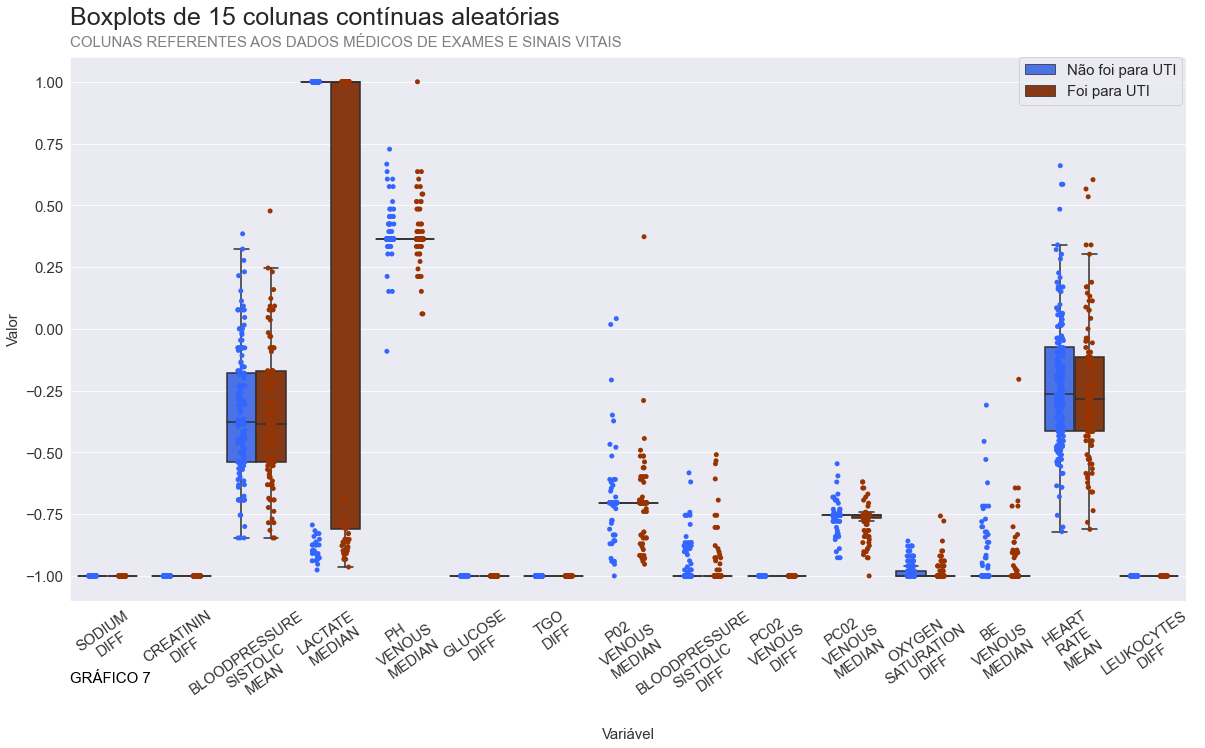

In [50]:
#Criando a figura
fig, ax = plt.subplots(figsize=(20,10))

#Criando os boxplots
sns.boxplot(x='variable', y='value', hue='ICU',
            data=cont_melt, palette=['#3366ff', '#993300'], 
            ax=ax, showfliers=False)

#Criando os stripsplots
sns.stripplot(x='variable', y='value', hue='ICU',
              data=cont_melt, palette=['#3366ff', '#993300'],
              ax=ax, dodge=True)

#Plotando rótulos e títulos
labs(title='Boxplots de 15 colunas contínuas aleatórias', 
     xlabel='Variável', 
     ylabel='Valor', 
     subtitle='COLUNAS REFERENTES AOS DADOS MÉDICOS DE EXAMES E SINAIS VITAIS', ax=ax)

#Configurando o eixo x
plt.xticks(range(15),labels=cont_melt['variable'].str.split('_').str.join('\n').unique(), rotation=35)

#Configurando a legenda
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Não foi para UTI', 'Foi para UTI'], bbox_to_anchor=(0.85, 1), loc=2, borderaxespad=0., fontsize=15)

#Adicionando uma referência para o gráfico
plt.text(0,-0.15, 'GRÁFICO 7', color='black', transform=ax.transAxes, fontsize=15)
plt.show()

A partir dos boxplots percebemos que algumas variáveis parecem realmente ter uma variância muito baixa, como a "SODIUM DIFF", "CREATININ DIFF", e as demais que representam diferenças. Por outro lado, percebe-se uma diferença muito grande dos valores de quem foi para UTI e de quem não foi na variável "LACTATE MEDIAN, podendo indicar que essa variável seja importante na hora de modelar os dados.<br><br>
Por esta razão vou eliminar todas aquelas variáveis com um valor de variância igual a 0.

In [51]:
#Criando uma série com as variâncias para cada coluna numérica
var = df.select_dtypes('float64').var()
#Ordenando em ordem crescente e mostrando os primeiros valores
var.sort_values().head()

PC02_ARTERIAL_DIFF    0.0
PH_ARTERIAL_DIFF      0.0
HEMATOCRITE_DIFF      0.0
HEMOGLOBIN_DIFF       0.0
INR_DIFF              0.0
dtype: float64

Observando os primeiros valores já percebe-se que temos algumas colunas com variância igual a 0.

In [52]:
#Selecionando as colunas com variância igual a 0
cols_0_var = [col for col in var.index if var[col] == 0]
#Imprimindo na tela as colunas com variância igual a 0
print(cols_0_var)
#Mostrando na tela a quantidade de colunas
print(len(cols_0_var))

['ALBUMIN_DIFF', 'BE_ARTERIAL_DIFF', 'BE_VENOUS_DIFF', 'BIC_ARTERIAL_DIFF', 'BIC_VENOUS_DIFF', 'BILLIRUBIN_DIFF', 'BLAST_DIFF', 'CALCIUM_DIFF', 'CREATININ_DIFF', 'FFA_DIFF', 'GGT_DIFF', 'GLUCOSE_DIFF', 'HEMATOCRITE_DIFF', 'HEMOGLOBIN_DIFF', 'INR_DIFF', 'LACTATE_DIFF', 'LEUKOCYTES_DIFF', 'LINFOCITOS_DIFF', 'NEUTROPHILES_DIFF', 'P02_ARTERIAL_DIFF', 'P02_VENOUS_DIFF', 'PC02_ARTERIAL_DIFF', 'PC02_VENOUS_DIFF', 'PCR_DIFF', 'PH_ARTERIAL_DIFF', 'PH_VENOUS_DIFF', 'PLATELETS_DIFF', 'POTASSIUM_DIFF', 'SAT02_ARTERIAL_DIFF', 'SAT02_VENOUS_DIFF', 'SODIUM_DIFF', 'TGO_DIFF', 'TGP_DIFF', 'TTPA_DIFF', 'UREA_DIFF', 'DIMER_DIFF']
36


Podemos perceber que temos 36 colunas com variância igual a 0 no dataset, e, por esta razão irei eliminá-las.

In [53]:
#Eliminando as colunas com variância igual a 0
df.drop(cols_0_var,axis=1, inplace=True)

In [54]:
df.head()

,AGE_ABOVE65,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,...,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,ICU,AGE_UNDER_30th,AGE_UNDER_50th,AGE_ABOVE_50th,AGE_ABOVE_80th
0,1,0,0,0,0,1,1,0,0,1,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,1,...,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,1,1,1,0,0
2,0,0,0,0,0,0,0,0,1,1,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,...,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0,1,1,0,0
4,0,0,0,0,0,0,0,0,0,1,...,-0.984733,-1.000000,-0.976190,-0.979798,-0.986481,0,1,1,0,0


In [55]:
df.shape

(294, 61)

Podemos ver que saímos de 231 para 62 colunas e agora chegou o momento de testar os modelos de Machine Learning a fim de solucionar o problema. Para isso vou salvar esses dados pré-processados na pasta [dados/dados_preprocessados](https://github.com/PedroHCAlmeida/Projeto_final_bootcamp/tree/main/dados/dados_preprocessados). E continuar o trabalho no notebook, dedicado aos modelos, [notebooks/Previsoes](https://github.com/PedroHCAlmeida/Projeto_final_bootcamp/blob/main/notebooks/Previsoes.ipynb).

# Salvando dados pré-processados

In [56]:
df.to_csv('../dados/dados_preprocessados/preprocessados.csv', index=False)